## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from wordcloud import WordCloud,STOPWORDS

# import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Model Training

#### Train Test Split

In [2]:
# Read Processed Comments:
from scipy.sparse import csr_matrix
def load_sparse_csr(filename):
    # here we need to add .npz extension manually
    loader = np.load(filename + '.npz')
    return csr_matrix((loader['data'], 
                        loader['indices'], 
                        loader['indptr']),
                        shape=loader['shape'])

X = load_sparse_csr('word_count')
X

<50000x70847 sparse matrix of type '<class 'numpy.int64'>'
	with 4637943 stored elements in Compressed Sparse Row format>

In [3]:
# Keep selected features only
features = open("feature_selection.txt","r")
index = []
for line in features.readlines():
    index.append(int(line.rstrip()))

X=X[:,index]
X

<50000x40000 sparse matrix of type '<class 'numpy.int64'>'
	with 4584933 stored elements in Compressed Sparse Row format>

In [4]:
# train_test_split
from sklearn.model_selection import train_test_split
y = pd.read_csv('sentiment', header=None).to_numpy().flatten()

#y must be a dense vector
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state = 1) 

#### Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(estimator = LogisticRegression(max_iter = 1000),
               param_grid = param_grid,
               refit = True,
               n_jobs = -1,
               cv=10)

In [6]:
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print("Regularization aprameter c selected for the final model is",clf.best_params_)
print(accuracy_score(y_test, y_predict))

Regularization aprameter c selected for the final model is {'C': 0.1}
0.8896


(6610, 766, 890, 6734)


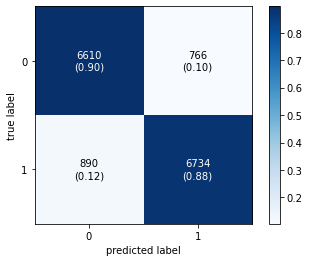

In [7]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_predict, y_test).ravel()
print(str((tn, fp, fn, tp)))

cm = np.array([[tn,fp],
              [fn, tp]])

fig, ax = plot_confusion_matrix(conf_mat = cm,
                                show_absolute=True,
                                show_normed = True,
                                colorbar = True)
plt.show()

[ 3500 11375 19250 27125 35000]


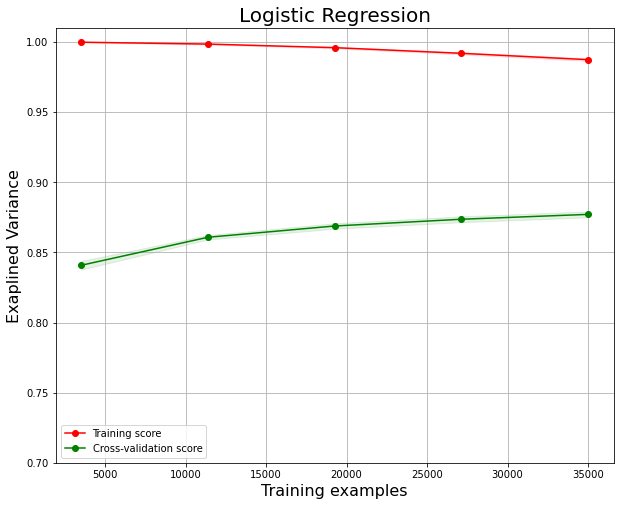

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    fig, ax = plt.subplots(figsize = (10,8))
    ax.set_title(title, fontsize = 20)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples", fontsize = 16)
    

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    print(train_sizes)

    # Plot learning curve
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax.legend(loc="best")
    ax.set_ylabel("Exaplined Variance", fontsize = 16)

    return plt




title = "Logistic Regression"
estimator = LogisticRegression()
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=1)

plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.savefig('Learning_curve_logistic')
plt.show()

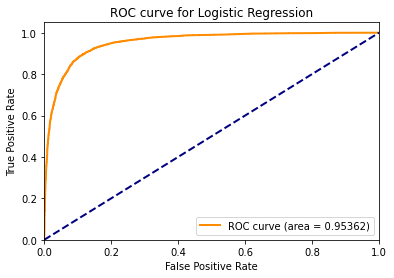

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area 
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = clf.fit(X_train, y_train).decision_function(X_test)


fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('ROC_logistic')
plt.show()

In [10]:
np.savetxt('y_predict_logistic', y_predict, delimiter=',')